In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv("./datasets/train.csv")
test_df = pd.read_csv("./datasets/test.csv")

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
# Separate label from core dataframe
y_train, y_test = train_df["label"], test_df["label"]
del train_df["label"]
del test_df["label"]

x_train, x_test = train_df.values, test_df.values

In [5]:
x_train, y_train

(array([[107, 118, 127, ..., 204, 203, 202],
        [155, 157, 156, ..., 103, 135, 149],
        [187, 188, 188, ..., 195, 194, 195],
        ...,
        [174, 174, 174, ..., 202, 200, 200],
        [177, 181, 184, ...,  64,  87,  93],
        [179, 180, 180, ..., 205, 209, 215]]),
 0         3
 1         6
 2         2
 3         2
 4        13
          ..
 27450    13
 27451    23
 27452    18
 27453    17
 27454    23
 Name: label, Length: 27455, dtype: int64)

In [6]:
x_test, y_test

(array([[149, 149, 150, ..., 112, 120, 107],
        [126, 128, 131, ..., 184, 182, 180],
        [ 85,  88,  92, ..., 225, 224, 222],
        ...,
        [190, 191, 190, ..., 211, 209, 208],
        [201, 205, 208, ...,  67,  70,  63],
        [173, 174, 173, ..., 195, 193, 192]]),
 0        6
 1        5
 2       10
 3        0
 4        3
         ..
 7167     1
 7168    12
 7169     2
 7170     4
 7171     2
 Name: label, Length: 7172, dtype: int64)

In [7]:
# Normalize pixels data
x_test = x_test / 255
x_train = x_train / 255

In [8]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [9]:
# Reshape input data to match convnet input dimension
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [10]:
# Split train and validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

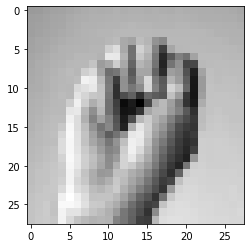

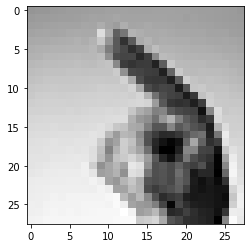

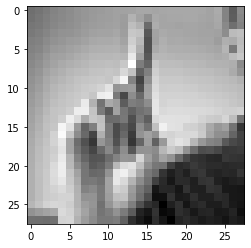

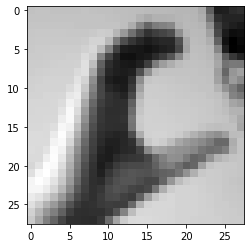

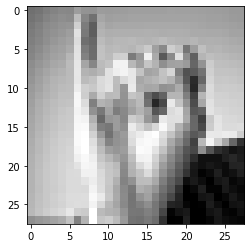

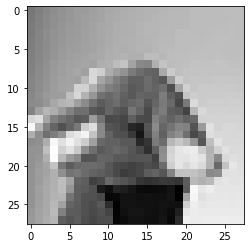

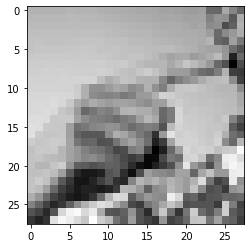

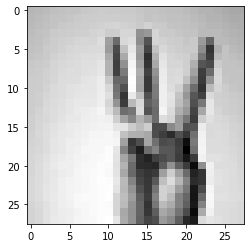

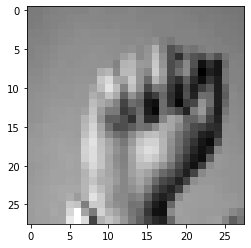

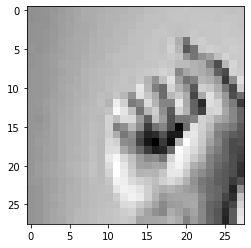

In [11]:
for i in range(10):
    plt.imshow(x_train[i], cmap="gray")
    plt.show()

In [12]:
model = Sequential()

model.add(Conv2D(75, (3,3), padding="same", strides=1, input_shape=(28, 28, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="same"))

model.add(Conv2D(50, (3,3), padding="same", strides=1, activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="same"))

model.add(Conv2D(25, (3,3), padding="same", strides=1, activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding="same"))

model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 25)          11275     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 25)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0

In [14]:
# Data augmentation using keras ImageDataGenerator API
data_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.0,
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
)

In [15]:
data_generator.fit(x_train)

In [16]:
# Training callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
!rm -rf ./logs/ 
log_dir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=3)

In [17]:
history = model.fit(
        data_generator.flow(x_train,y_train, batch_size = 128) ,
        epochs = 20 , 
        validation_data=(x_val, y_val),
        callbacks = [learning_rate_reduction, early_stopping_callback, tensorboard_callback]
        )

Epoch 1/20
  1/161 [..............................] - ETA: 0s - loss: 3.1909 - accuracy: 0.0469WARNING:tensorflow:From /Users/welvin/Documents/Dev/linguist/env/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
161/161 [==============================] - 15s 92ms/step - loss: 2.4258 - accuracy: 0.2648 - val_loss: 1.0774 - val_accuracy: 0.6656
Epoch 2/20
161/161 [==============================] - 15s 94ms/step - loss: 1.0312 - accuracy: 0.6602 - val_loss: 0.4294 - val_accuracy: 0.8770
Epoch 3/20
161/161 [==============================] - 16s 98ms/step - loss: 0.5704 - accuracy: 0.8076 - val_loss: 0.1691 - val_accuracy: 0.9490
Epoch 4/20
161/161 [==============================] - 15s 95ms/step - loss: 0.3403 - accuracy: 0.8864 - val_loss: 0.0863 - val_accuracy: 0.9796
Epoch 5/20
161/161 [============

In [18]:
model.evaluate(x_test, y_test)

225/225 [==============================] - 1s 6ms/step - loss: 0.0281 - accuracy: 0.9969


[0.028148679062724113, 0.9969325065612793]

In [19]:
model.save('model.h5')

In [20]:
history.history

{'loss': [2.4258432388305664,
  1.0312449932098389,
  0.5703982710838318,
  0.34030500054359436,
  0.2425725758075714,
  0.1773630678653717,
  0.14319095015525818,
  0.12187296897172928,
  0.09592675417661667,
  0.07736266404390335,
  0.06810779124498367,
  0.06738723814487457,
  0.055738043040037155,
  0.051393188536167145,
  0.043004997074604034,
  0.04989513009786606,
  0.027058757841587067,
  0.019877007231116295,
  0.017200754955410957,
  0.01612524501979351],
 'accuracy': [0.2647758722305298,
  0.6601913571357727,
  0.8075858354568481,
  0.8863581418991089,
  0.9195765256881714,
  0.9419649243354797,
  0.95196932554245,
  0.9599339365959167,
  0.9681900143623352,
  0.9739692211151123,
  0.9784857630729675,
  0.9781943559646606,
  0.981788158416748,
  0.9830994009971619,
  0.9859161972999573,
  0.9833422303199768,
  0.9916468262672424,
  0.9932494759559631,
  0.9942207932472229,
  0.9952406287193298],
 'val_loss': [1.0774157047271729,
  0.4294396638870239,
  0.16914303600788116,
 